In [39]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad

%matplotlib inline

# Stein Variational Gradient Descent
### by Qiang Liu, Dilin Wang (https://arxiv.org/abs/1608.04471)

Particles explore the posterior according to the following iterative algorithm
$$ \theta_{i}^{l+1} \leftarrow \theta_{i}^{l} + \epsilon \boldsymbol{\hat \phi}(\theta_{i}^{l}) \text{  where  } \boldsymbol{\hat \phi}(\theta_{i}^{l}) = \frac{1}{n} \sum_{j=1}^{n} k(\theta_{j}^{l}, \theta) \nabla_{\theta_{j}^{l}} \log p(\theta_{j}^{l}) + \nabla_{\theta_{j}^{l}} k(\theta_{j}^{l}, \theta)$$
where $k$ is a valid kernel and $\epsilon$ is a step-size.  The operator $\boldsymbol{\hat \phi}(\theta_{i}^{l})$ is implemented below:

### Kernels for $\mathbb{R}^{d}$

In [107]:
# Probability Product Kernel
def prob_prod(z1_mu, z1_log_sigma, z2_mu, z2_log_sigma, scale=1.):
    
    z1_sigma = np.exp(z1_log_sigma)
    z2_sigma = np.exp(z2_log_sigma)

    rho = 1./scale
    sigma_star = 1./z1_sigma + 1./z2_sigma
    mu_star = z1_mu/z1_sigma + z2_mu/z2_sigma
    norm = (2*3.14)**((1.-2*rho)*(1./2.)) * rho**(-.5) * sigma_star**.5 * z1_sigma**(-rho/2.) * z2_sigma**(-rho/2.)

    return norm * np.exp( -rho/2. * ((z1_mu**2)/z1_sigma + (z2_mu**2)/z2_sigma - (mu_star**2)/sigma_star ) )

def prob_prod2(z1_log_sigma, z1_mu, z2_mu, z2_log_sigma, scale=1.):
    
    z1_sigma = np.exp(z1_log_sigma)
    z2_sigma = np.exp(z2_log_sigma)

    rho = 1./scale
    sigma_star = 1./z1_sigma + 1./z2_sigma
    mu_star = z1_mu/z1_sigma + z2_mu/z2_sigma
    norm = (2*3.14)**((1.-2*rho)*(1./2.)) * rho**(-.5) * sigma_star**.5 * z1_sigma**(-rho/2.) * z2_sigma**(-rho/2.)

    return norm * np.exp( -rho/2. * ((z1_mu**2)/z1_sigma + (z2_mu**2)/z2_sigma - (mu_star**2)/sigma_star ) )


# Radial Basis Function (Heat Kernel)
def rbf(x1, x2, params={'lengthScale': 5.}):
    return np.exp((-.5/params['lengthScale']) * np.sum((x1-x2)**2))

## Models

### Gaussian Mixture Model (lower bound)

[{'mu': -2.7088919464057075, 'log_sigma': 0.37617744091226413}, {'mu': 4.1978374428565512, 'log_sigma': 1.4567301351419348}]


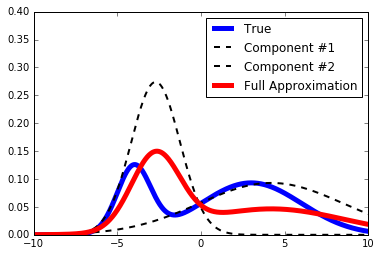

In [24]:
# Model
def gaussPdf(x, params):
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

def gaussEntropy(log_sigma):
    return .5 * (np.log(2*np.pi*np.e) + 2.*log_sigma)

def logGaussMixPDF(x, params):
    return np.log(params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]}))

# get model grad wrt sample
logModel = logGaussMixPDF
dLogModel = grad(logModel)

# get entropy grad wrt log sigma
dEntropy_dLogSigma = grad(gaussEntropy)

# kernel
kernel = {'f': prob_prod}
kernel['df_mu'] = grad(kernel['f'])
kernel['df_lsig'] = grad(prob_prod2)

params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

# initial distribution
q0 = np.random.normal

### generate samples
n = 2
psi = []
for sampleIdx in xrange(n):
    psi.append( {'mu':q0(), 'log_sigma':0.} )
    
    
# Modified Stein Op
def steinOp(vi_params, idx, dLogModel, params, dEntropy, kernel, kernelParams=None):
    
    returnVal_mu = 0.
    returnVal_logSigma = 0.
    
    K = len(vi_params)
    for k in xrange(K):
        
        epsilon = np.random.normal()
        x_sample = vi_params[k]['mu'] + epsilon * np.exp(vi_params[k]['log_sigma'])
        
        grad_mu = dLogModel(x_sample, params) * 1. 
        
        grad_log_sigma = dLogModel(x_sample, params) * epsilon * np.exp(vi_params[k]['log_sigma'])
        grad_log_sigma += dEntropy(vi_params[k]['log_sigma'])
        
        returnVal_mu += kernel['f'](vi_params[k]['mu'], vi_params[k]['log_sigma'], vi_params[idx]['mu'], vi_params[idx]['log_sigma']) * grad_mu 
        returnVal_mu += kernel['df_mu'](vi_params[k]['mu'], vi_params[k]['log_sigma'], vi_params[idx]['mu'], vi_params[idx]['log_sigma'])
        
        returnVal_logSigma += kernel['f'](vi_params[k]['mu'], vi_params[k]['log_sigma'], vi_params[idx]['mu'], vi_params[idx]['log_sigma']) * grad_log_sigma
        returnVal_logSigma += kernel['df_lsig'](vi_params[k]['log_sigma'], vi_params[k]['mu'], vi_params[idx]['mu'], vi_params[idx]['log_sigma'])

    return (1./K * returnVal_mu, 1./K * returnVal_logSigma)
    
    
maxEpochs = 1000
lr_mu = .1
lr_sig = .05
for epochIdx in xrange(maxEpochs):
    for idx in xrange(n):
        update = steinOp(psi, idx, dLogModel, params, dEntropy_dLogSigma, kernel)
        psi[idx]['mu'] += lr_mu * update[0]
        psi[idx]['log_sigma'] += lr_sig * update[1]
        
print psi
        
plt.figure()

# plot true distributions
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]
plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")

# plot latent
colors = ['r','g','y','m']
probs_approx = []
for k in xrange(n):
    probs_approx.append([gaussPdf(z, {'mu':psi[k]['mu'], 'sigma':np.exp(psi[k]['log_sigma'])}) for z in x_true]) 
    plt.plot(x_true, probs_approx[-1], '--k', linewidth=2, label="Component #%d" %(k+1))
    
full_approx = np.zeros(x_true.shape[0])
for k in xrange(n):
    full_approx += 1./n * np.array(probs_approx[k])
plt.plot(x_true, full_approx, '-r', linewidth=5, label="Full Approximation")
    
plt.xlim([-10,10])
plt.ylim([0,.4])
plt.legend()
plt.show()

### Gaussian Mixture Model (importance sampled)

[{'mu': -4.0006557441602233, 'log_sigma': -0.028449846648394179}, {'mu': 4.7835780497250964, 'log_sigma': 0.31589535237965799}, {'mu': -0.7364172588225345, 'log_sigma': 0.67586327839096161}, {'mu': 1.7320687856966053, 'log_sigma': 0.60708734400232089}]


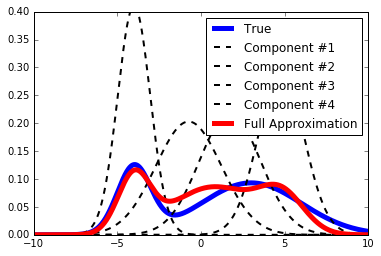

In [112]:
# Model
def gaussPdf(x, params):
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

def gaussEntropy(log_sigma):
    return .5 * (np.log(2*np.pi*np.e) + 2.*log_sigma)

def logGaussMixPDF(x, params):
    return np.log(params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]}))

# get model grad wrt sample
logModel = logGaussMixPDF
dLogModel = grad(logModel)

# get entropy grad wrt log sigma
dEntropy_dLogSigma = grad(gaussEntropy)

# kernel
kernel = {'f': prob_prod}
kernel['df_mu'] = grad(kernel['f'])
kernel['df_lsig'] = grad(prob_prod2)

params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

# initial distribution
q0 = np.random.normal

### generate samples
n = 4
psi = []
for sampleIdx in xrange(n):
    psi.append( {'mu':q0(), 'log_sigma':0.} )
    
    
# Modified Stein Op
def steinOp(vi_params, idx, dLogModel, params, dEntropy, kernel, kernelParams=None, n_is=3):
    
    returnVal_mu = 0.
    returnVal_logSigma = 0.
    
    K = len(vi_params)
    for k in xrange(K):
        
        grad_mus = []
        grad_log_sigmas = []
        w_is = []
        
        for idx_is in xrange(n_is):
            epsilon = np.random.normal() 
            x_sample = vi_params[k]['mu'] + epsilon * np.exp(vi_params[k]['log_sigma'])
            
            w_is.append( np.exp(logModel(x_sample, params) - \
                                np.log(gaussPdf(x_sample, {'mu':vi_params[k]['mu'], 'sigma':np.exp(vi_params[k]['log_sigma'])}))) )
        
            grad_mus.append(dLogModel(x_sample, params) * 1.)
            grad_mus[-1] -= (vi_params[k]['mu'] - x_sample)/np.exp(2*vi_params[k]['log_sigma']) * 1. 
            grad_mus[-1] -= -(vi_params[k]['mu'] - x_sample)/np.exp(2*vi_params[k]['log_sigma']) 
        
            grad_log_sigmas.append( dLogModel(x_sample, params) * epsilon * np.exp(vi_params[k]['log_sigma']) )
            grad_log_sigmas[-1] -= (vi_params[k]['mu'] - x_sample)/np.exp(2*vi_params[k]['log_sigma']) * epsilon * np.exp(vi_params[k]['log_sigma']) 
            grad_log_sigmas[-1] -= ( (vi_params[k]['mu'] - x_sample)**2 / np.exp(3*vi_params[k]['log_sigma']) \
                                    - 1./np.exp(vi_params[k]['log_sigma']) ) * np.exp(vi_params[k]['log_sigma'])  
            
        w_normalizer = np.sum(w_is)
        
        grad_mu = np.sum([ w_is[idx_is]/w_normalizer * grad_mus[idx_is] for idx_is in range(n_is) ])
        grad_log_sigma = np.sum([ w_is[idx_is]/w_normalizer * grad_log_sigmas[idx_is] for idx_is in range(n_is) ])
        
        returnVal_mu += kernel['f'](vi_params[k]['mu'], vi_params[k]['log_sigma'], vi_params[idx]['mu'], vi_params[idx]['log_sigma']) * grad_mu 
        returnVal_mu += kernel['df_mu'](vi_params[k]['mu'], vi_params[k]['log_sigma'], vi_params[idx]['mu'], vi_params[idx]['log_sigma'])
        
        returnVal_logSigma += kernel['f'](vi_params[k]['mu'], vi_params[k]['log_sigma'], vi_params[idx]['mu'], vi_params[idx]['log_sigma']) * grad_log_sigma
        returnVal_logSigma += kernel['df_lsig'](vi_params[k]['log_sigma'], vi_params[k]['mu'], vi_params[idx]['mu'], vi_params[idx]['log_sigma'])

    return (1./K * returnVal_mu, 1./K * returnVal_logSigma)
    
    
maxEpochs = 1201
lr_mu = .1
lr_sig = .01
for epochIdx in xrange(maxEpochs):
    for idx in xrange(n):
        update = steinOp(psi, idx, dLogModel, params, dEntropy_dLogSigma, kernel)
        psi[idx]['mu'] += lr_mu * update[0]
        psi[idx]['log_sigma'] += lr_sig * update[1]
        
print psi
        
plt.figure()

# plot true distributions
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]
plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")

# plot latent
colors = ['r','g','y','m']
probs_approx = []
for k in xrange(n):
    probs_approx.append([gaussPdf(z, {'mu':psi[k]['mu'], 'sigma':np.exp(psi[k]['log_sigma'])}) for z in x_true]) 
    plt.plot(x_true, probs_approx[-1], '--k', linewidth=2, label="Component #%d" %(k+1))
    
full_approx = np.zeros(x_true.shape[0])
for k in xrange(n):
    full_approx += 1./n * np.array(probs_approx[k])
plt.plot(x_true, full_approx, '-r', linewidth=5, label="Full Approximation")
    
plt.xlim([-10,10])
plt.ylim([0,.4])
plt.legend()
plt.show()

### Gaussian Mixture Model (mf-elbo)

[{'mu': 3.6529557973470381, 'unnorm_pi': 7.1769422768899496, 'log_sigma': 0.98763392947868933}, {'mu': -3.577780513918591, 'unnorm_pi': 7.1196115305967638, 'log_sigma': 0.3722920056123516}]
[ 0.51432876  0.48567124]


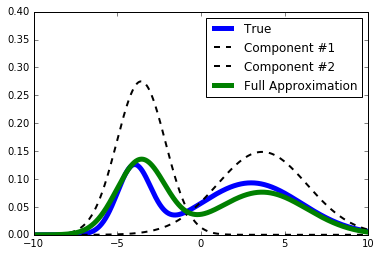

In [68]:
# Model
def gaussPdf(x, params):
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

def gaussEntropy(log_sigma):
    return .5 * (np.log(2*np.pi*np.e) + 2.*log_sigma)

def logGaussMixPDF(x, params):
    return np.log(params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]}))

# get model grad wrt sample
logModel = logGaussMixPDF
dLogModel = grad(logModel)

# get entropy grad wrt log sigma
dEntropy_dLogSigma = grad(gaussEntropy)

params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

# initial distribution
q0 = np.random.normal

### generate samples
n = 2
psi = []
for sampleIdx in xrange(n):
    psi.append( {'unnorm_pi': 0., 'mu':q0(), 'log_sigma':0.} )
    
    
# Modified Stein Op
def mfElboOp(vi_params, dLogModel, params, dEntropy, alpha=1.):
    
    grad_unnorm_pis = [0.] * len(vi_params)
    grad_mus = []
    grad_log_sigmas = []
    
    exp_pis = [np.exp(vi_params[i]['unnorm_pi']) for i in range(len(vi_params))]
    Z_pi = np.sum(exp_pis)
           
    for idx in range(len(vi_params)):
    
        # update model terms
    
        epsilon = np.random.normal()
        x_sample = vi_params[idx]['mu'] + epsilon * np.exp(vi_params[idx]['log_sigma'])
        
        ll = dLogModel(x_sample, params)
        
        grad_mus.append(exp_pis[idx]/Z_pi * ll * 1.) 
        
        grad_log_sigmas.append(exp_pis[idx]/Z_pi * (ll * epsilon * np.exp(vi_params[idx]['log_sigma'])))
        
        grad_unnorm_pis[idx] += (ll) * (exp_pis[idx]/Z_pi - exp_pis[idx]**2 / Z_pi**2) # + (alpha-1.)/(exp_pis[idx]/Z_pi)
        
        for k in range(len(vi_params)):
            if k == idx: continue
            grad_unnorm_pis[k] += (ll) * (-exp_pis[idx] / Z_pi**2 * exp_pis[k])
            
    # update entropy terms
    
    temp_g_pis = [0.] * len(vi_params)
    temp_g_mus = [0.] * len(vi_params)
    temp_g_log_sigmas = [0.] * len(vi_params)
    
    Z = [0.] * len(vi_params)
    for k in xrange(len(vi_params)):
        for j in xrange(len(vi_params)):
            Z[k] += exp_pis[j]/Z_pi * \
            gaussPdf(vi_params[k]['mu'], \
                     {'mu':vi_params[j]['mu'],'sigma':np.sqrt(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))})
                                                            
    for k in range(len(vi_params)):
        for j in range(len(vi_params)):
            
            if j != k:
                
                ### mu update
                temp_g_mus[k] += -exp_pis[k]/Z_pi * 1./Z[k] * exp_pis[j]/Z_pi * \
                gaussPdf(vi_params[k]['mu'],{'mu':vi_params[j]['mu'],'sigma':np.sqrt(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))}
                    ) * \
                (vi_params[j]['mu'] - vi_params[k]['mu'])/(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))
                
                temp_g_mus[k] += -exp_pis[j]/Z_pi * 1./Z[j] * exp_pis[k]/Z_pi * \
                gaussPdf(vi_params[j]['mu'],{'mu':vi_params[k]['mu'],'sigma':np.sqrt(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))}
                    ) * \
                -(vi_params[k]['mu'] - vi_params[j]['mu'])/(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))
        
                ### sigma update
                temp_g_log_sigmas[k] += -exp_pis[k]/Z_pi * 1./Z[k] * exp_pis[j]/Z_pi * \
                gaussPdf(vi_params[k]['mu'],{'mu':vi_params[j]['mu'],'sigma':np.sqrt(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))}
                    ) * 2 * np.exp(vi_params[k]['log_sigma']) * \
                (.5*(vi_params[j]['mu'] - vi_params[k]['mu'])**2/(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))**2
                + -.5*(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))**(-1)) * np.exp(vi_params[k]['log_sigma'])
                
                temp_g_log_sigmas[k] += -exp_pis[j]/Z_pi * 1./Z[j] * exp_pis[k]/Z_pi * \
                gaussPdf(vi_params[j]['mu'],{'mu':vi_params[k]['mu'],'sigma':np.sqrt(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))}
                  ) * 2 * np.exp(vi_params[k]['log_sigma']) * \
                (.5*(vi_params[k]['mu'] - vi_params[j]['mu'])**2/(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))**2
                + -.5*(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))**(-1)) * np.exp(vi_params[k]['log_sigma'])
                
                ### pi update
                temp_g_pis[k] += -exp_pis[j]/Z_pi * 1./Z[j] * \
                gaussPdf(vi_params[j]['mu'],{'mu':vi_params[k]['mu'],'sigma':np.sqrt(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))}
                  ) * (exp_pis[k]/Z_pi - exp_pis[k]**2 / Z_pi**2)
                
            
            if j == k:
                temp_g_log_sigmas[k] += -exp_pis[k]/Z_pi * 1./Z[k] * exp_pis[j]/Z_pi * \
                gaussPdf(vi_params[k]['mu'],{'mu':vi_params[k]['mu'],'sigma':np.sqrt(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))}
                  ) * 4 * np.exp(vi_params[k]['log_sigma']) * \
                (-.5*(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))**(-1)) * np.exp(vi_params[k]['log_sigma'])
                
                
        temp_g_pis[k] += -np.log(Z[k]) * (exp_pis[k]/Z_pi - exp_pis[k]**2 / Z_pi**2)
        temp_g_pis[k] += -exp_pis[k]/Z_pi * 1./Z[k] * \
        gaussPdf(vi_params[k]['mu'],{'mu':vi_params[k]['mu'],'sigma':np.sqrt(np.exp(2*vi_params[k]['log_sigma'])+np.exp(2*vi_params[j]['log_sigma']))}
                    ) * (exp_pis[k]/Z_pi - exp_pis[k]**2 / Z_pi**2)
        
        grad_unnorm_pis[k] += temp_g_pis[k]
        grad_mus[k] += temp_g_mus[k]
        grad_log_sigmas[k] += temp_g_log_sigmas[k]
            
    
    return (grad_unnorm_pis, grad_mus, grad_log_sigmas)
    
    
maxEpochs = 2000
lr_mu = .1
lr_sig = .01
lr_pi = .01
for epochIdx in xrange(maxEpochs):
    update = mfElboOp(psi, dLogModel, params, dEntropy_dLogSigma)
    for idx in xrange(n):
        psi[idx]['mu'] += lr_mu * update[1][idx]
        psi[idx]['log_sigma'] += lr_sig * update[2][idx]
        psi[idx]['unnorm_pi'] += lr_pi * update[0][idx]
        
final_pis = np.array([np.exp(psi[i]['unnorm_pi']) for i in range(n)])
final_pis /= np.sum(final_pis)

print psi
print final_pis
        
plt.figure()

# plot true distributions
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]
plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")

# plot latent
colors = ['r','g','y','m']
probs_approx = []
for k in xrange(n):
    probs_approx.append([gaussPdf(z, {'mu':psi[k]['mu'], 'sigma':np.exp(psi[k]['log_sigma'])}) for z in x_true]) 
    plt.plot(x_true, probs_approx[-1], '--k', linewidth=2, label="Component #%d" %(k+1))
    
full_approx = np.zeros(x_true.shape[0])
for k in xrange(n):
    full_approx += final_pis[k] * np.array(probs_approx[k])
plt.plot(x_true, full_approx, '-g', linewidth=5, label="Full Approximation")
    
plt.xlim([-10,10])
plt.ylim([0,.4])
plt.legend()
plt.show()